# Accelerated Machine Learning

Welcome to the Accelerated Machine Learning course at AIMS 2025.

This tutorial is based on the hls4ml tutorial notebooks (https://github.com/fastmachinelearning/hls4ml-tutorial/). The dataset is described in more detail in this article (https://iopscience.iop.org/article/10.1088/1748-0221/13/07/P07027/pdf). By the end of the course you will have:

* Trained a neural network to identify different types of "jets" at the Large Hadron Collider
* Used the hls4ml python library to convert the neural network to FPGA firmware
* Examined the FPGA resource usage for the neural network
* Understood floating point vs fixed point precision and the implications for inference accuracy and resource usage
* Implemented quantization-aware training using the QKeras library
* Tested the effect of "pruning" on the inference accuray and resource usage

## Part 1: Understanding the jet-tagging dataset

In this section we will import the dependencies and load the jet-tagging dataset. Following this we will take some time to understand the physics involved.

* **Pro-tip**: always understand your dataset!

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import os
from matplotlib import pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os
import ndjson

2025-04-24 12:53:19.243247: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 12:53:19.461131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-24 12:53:19.461191: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-24 12:53:19.462847: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 12:53:19.588449: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 12:53:19.589448: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Jets are one of the most important objects that we reconstruct at the Large Hadron Collider experiments. 
When fundamental particles, known as quarks or gluons, are produced in the proton-proton collisions,
they undergo a process called "hadronisation".
This creates narrow sprays of particles (hadrons) which are referred to as "jets".
By reconstructing and understanding these jets, we can infer properties of the fundamental particle interactions.
The image below shows a reconstruction of a collision event which produces two back-to-back jets with extremely high energy in the CMS detector.

<img src="figures/event_display_dijet.png" alt="Dijet event display" width="400"/>

In [2]:
# Load the dataset
data = fetch_openml('hls4ml_lhc_jets_hlf', as_frame=False, parser='liac-arff')
X, y = data['data'], data['target']
labels = np.unique(y)
features = data['feature_names']

print("Number of jets:", len(X))
print("Number of features:", len(features))
print("Different target classes:", labels)

Number of jets: 830000
Number of features: 16
Different target classes: ['g' 'q' 't' 'w' 'z']


These correspond to jets produced from a gluon (q), light-quark (q), top-quark (b), W-boson decay (w) and a Z-boson decay (z). 
Jets from the different classes will have different properties, and we can use these for identification.
A summary of the properties included in the dataset is provided in the table below.

<img src="figures/table_observables.png" alt="Table of observables" width="100"/>

The properties are described in more detail in this reference (https://arxiv.org/abs/1709.08705), but it is not important for you to know the exact details for this tutorial. Just that we have five different classes to predict, each of which have a different distribution in the high-dimensional jet property phase space.

Let's have a look at the 1D distributions for the different classes.

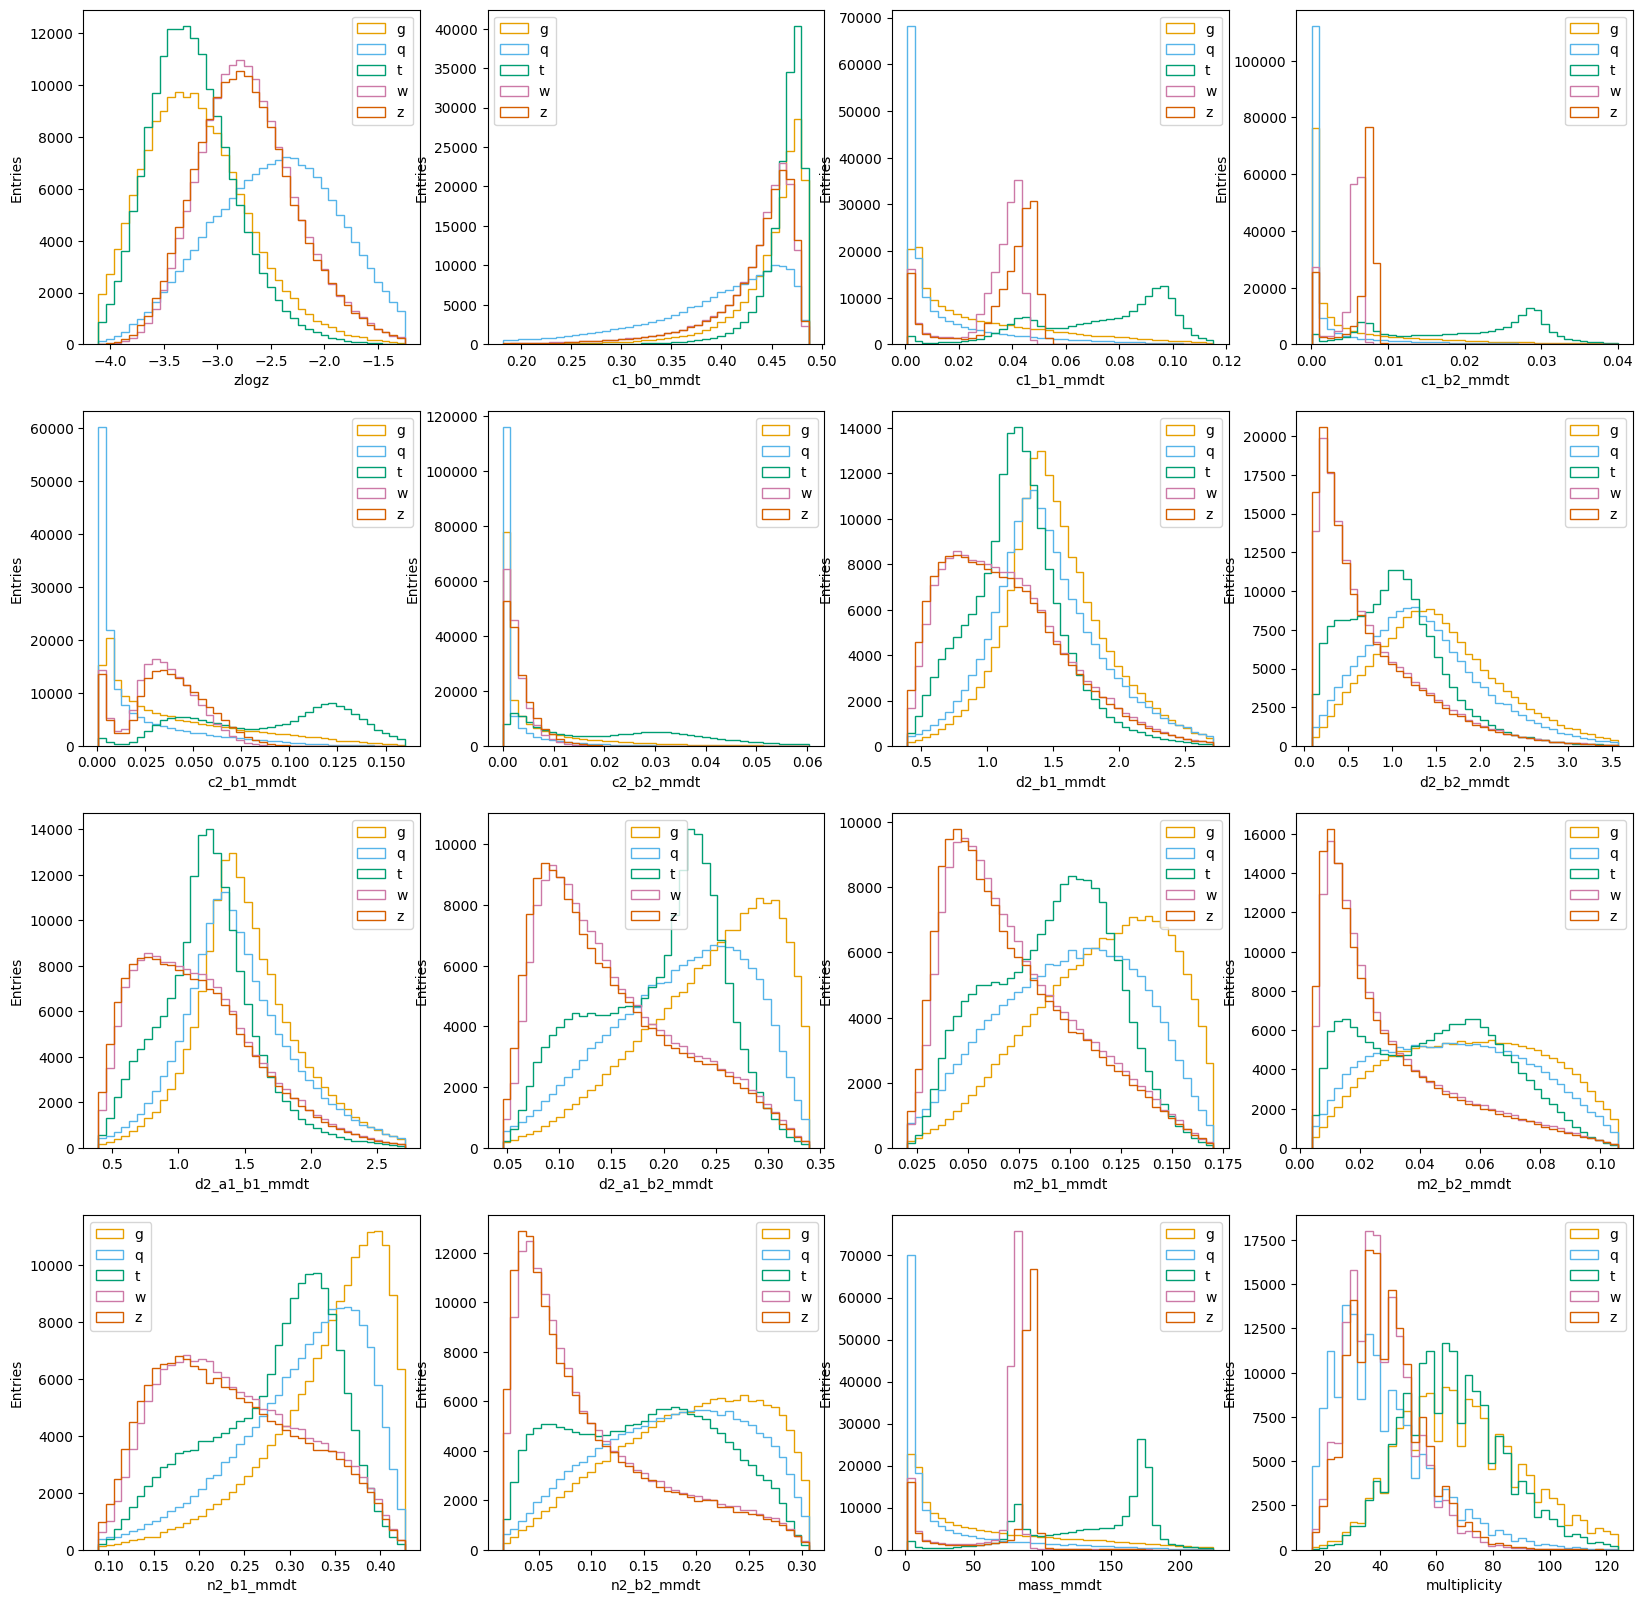

In [3]:
colors = [
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # green
    "#CC79A7",  # pink/purple
    "#D55E00",  # red/orange
]

def plot_input_feature(ax, X, y, features, x="zlogz", classes=['g','q','t','w','z'], bins=40):
    fi = np.where(np.array(features)==x)[0][0]
    vals = X.T[fi]

    # Obtain percentiles for sensible plot
    xlo, xhi = np.percentile(vals,0.5), np.percentile(vals,99.5)

    for i, c in enumerate(classes):
        mask = (y == c)
        ax.hist(vals[mask], bins=bins, range=(xlo,xhi), label=c, color=colors[i], histtype='step')

    ax.set_ylabel("Entries")
    ax.set_xlabel(x)
    ax.legend(loc='best')

fig, axs = plt.subplots(4,4, figsize=(20,20))
for k, feature in enumerate(features):
    i = int(np.floor(k/4))
    j = k%4
    plot_input_feature(axs[i][j], X, y, features, x=feature)

plt.show()

## Part 2: Create a simple neural network for jet-tagging

We are going to use the 16-dimensional information in the dataset to classify the different kinds of jets.
Let's do this with a simple feed-forward multi-layer perceptron.

First we need to do a bit of pre-processing:

In [4]:
# Add categorical labels and do the test-train split
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Do standard (z-score) scaling of the input features
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

# Save the datasets into the results folder for quick loading
np.save('results/X_train_val.npy', X_train_val)
np.save('results/X_test.npy', X_test)
np.save('results/y_train_val.npy', y_train_val)
np.save('results/y_test.npy', y_test)
np.save('results/classes.npy', le.classes_)

We will now load the relevant functionalities from tensorflow, and then build and train a neural network classifier.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

In [6]:
# Build the classifier
model = Sequential()
model.add(Dense(32, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

# Print summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 32)                544       
                                                                 
 relu1 (Activation)          (None, 32)                0         
                                                                 
 fc2 (Dense)                 (None, 32)                1056      
                                                                 
 relu2 (Activation)          (None, 32)                0         
                                                                 
 fc3 (Dense)                 (None, 32)                1056      
                                                                 
 relu3 (Activation)          (None, 32)                0         
                                                                 
 output (Dense)              (None, 5)                 1

<div style="background-color:#FFE5CC">
    
### Questions
* Do you understand the architecture of this MLP?
* What do the `kernel_initializer` and `kernal_regularizer` arguments for the dense layers do?
* Why might an L1 regularisation be appropriate for a network with limited resources?

In [7]:
# Train the network
N_epochs = 20
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

In [8]:
result = model.fit(
    X_train_val,
    y_train_val,
    batch_size=128,
    epochs=N_epochs,
    validation_split=0.25,
    shuffle=True,
)

Epoch 1/20
3891/3891 [==============================] - 5s 1ms/step - loss: 1.0502 - accuracy: 0.6440 - val_loss: 0.9024 - val_accuracy: 0.7117
Epoch 2/20
3891/3891 [==============================] - 4s 1ms/step - loss: 0.8624 - accuracy: 0.7206 - val_loss: 0.8448 - val_accuracy: 0.7251
Epoch 3/20
3891/3891 [==============================] - 4s 1ms/step - loss: 0.8275 - accuracy: 0.7286 - val_loss: 0.8215 - val_accuracy: 0.7299
Epoch 4/20
3891/3891 [==============================] - 4s 1ms/step - loss: 0.8068 - accuracy: 0.7336 - val_loss: 0.8027 - val_accuracy: 0.7347
Epoch 5/20
3891/3891 [==============================] - 4s 1ms/step - loss: 0.7905 - accuracy: 0.7377 - val_loss: 0.7886 - val_accuracy: 0.7389
Epoch 6/20
3891/3891 [==============================] - 5s 1ms/step - loss: 0.7784 - accuracy: 0.7414 - val_loss: 0.7785 - val_accuracy: 0.7422
Epoch 7/20
3891/3891 [==============================] - 5s 1ms/step - loss: 0.7699 - accuracy: 0.7444 - val_loss: 0.7712 - val_accuracy:

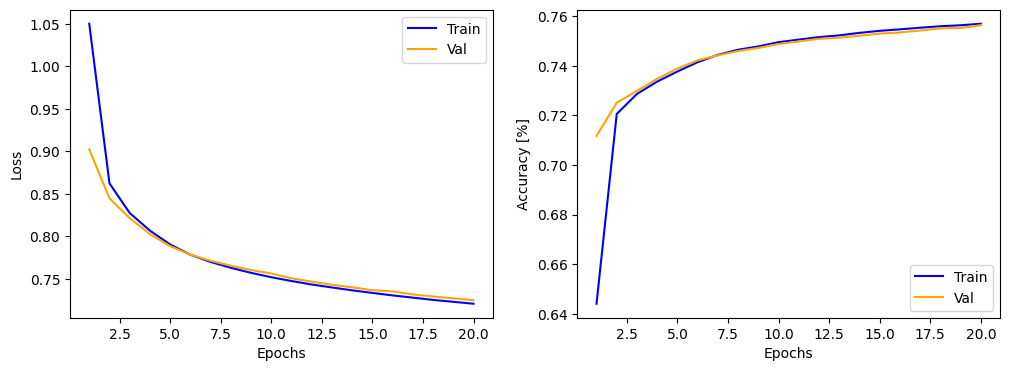

In [9]:
# Plot the training history
history = result.history

fig, axs = plt.subplots(1,2, figsize=(12,4))

epochs = np.linspace(1, N_epochs, N_epochs)
axs[0].plot(epochs, history['loss'], c='blue', label='Train')
axs[0].plot(epochs, history['val_loss'], c='orange', label='Val')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(loc='upper right')

axs[1].plot(epochs, history['accuracy'], c='blue', label='Train')
axs[1].plot(epochs, history['val_accuracy'], c='orange', label='Val')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy [%]")
axs[1].legend(loc='lower right')

<div style="background-color:#FFE5CC">

### Questions
* What conclusions can you draw from the shape of the loss curve?
    * **Hint**: comment on overtraining/undertraining

This tutorial is not about obtaining the best performance for the "software" neural network classifier, so we will not spend any more time improving the performance of this network. In any case, we should evaluate the performance on the test dataset to provide a "software" baseline.

Let's first calculate the global accuracy. This is defined as the fraction of correctly classified jets:

In [10]:
y_keras = model.predict(X_test)
keras_accuracy = np.sum(np.argmax(y_test, axis=1) == np.argmax(y_keras, axis=1))/y_test.shape[0]

print(f"Achieved test accuracy of {(100 * keras_accuracy):.2f}%")

5188/5188 [==============================] - 5s 874us/step
Achieved test accuracy of 75.52%


<div style="background-color:#C2F5DD">

### Exercise (extension)
We may want to understand the performance in more detail beyond the global accuracy.

It is interesting to evaluate how the model classifies one type of jet vs another. In this extension, we will 
1) Plot the output probabilities from the neural network (multi-)classifier
2) Evaluate the ROC curves
3) Plot the "confusion matrix" which tells us the fraction of predicted labels for each "truth" jet type

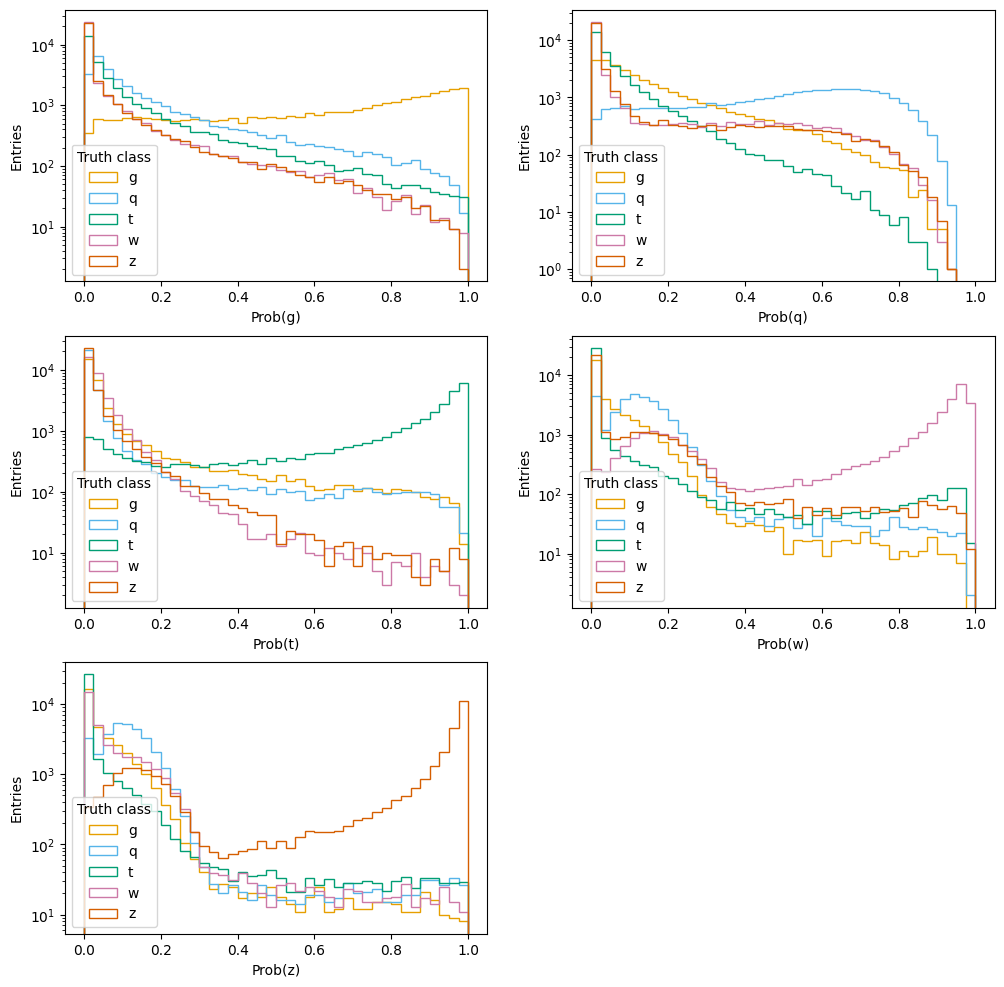

In [70]:
# SOLUTION 1)

# Build masks for truth class
masks = {}
for truth_label in labels:
    masks[truth_label] = np.sum((labels == truth_label)*y_test, axis=1, dtype='bool')

fig, axs = plt.subplots(3,2, figsize=(12,12))
axs[2,1].axis('off')

# Loop over predicted classes and plot the probabilities from the classifier
# Store the probabilities for future use
probs = {}
for j, pred_label in enumerate(list(labels)):

    x = int(np.floor(j/2))
    y = j%2
    
    arg = np.where(labels==pred_label)[0][0]
    prob = y_keras.T[arg]
    probs[pred_label] = prob

    lo, hi = 0, 1

    # Plot probability distribution for each truth class
    for i, truth_label in enumerate(list(labels)):
        mask = masks[truth_label]
        axs[x][y].hist(prob[mask], bins=40, range=(lo,hi), label=truth_label, histtype='step', color=colors[i])

    axs[x][y].set_xlabel(f"Prob({pred_label})")
    axs[x][y].set_ylabel("Entries")
    axs[x][y].set_yscale("log")
    axs[x][y].legend(loc='lower left', title="Truth class")

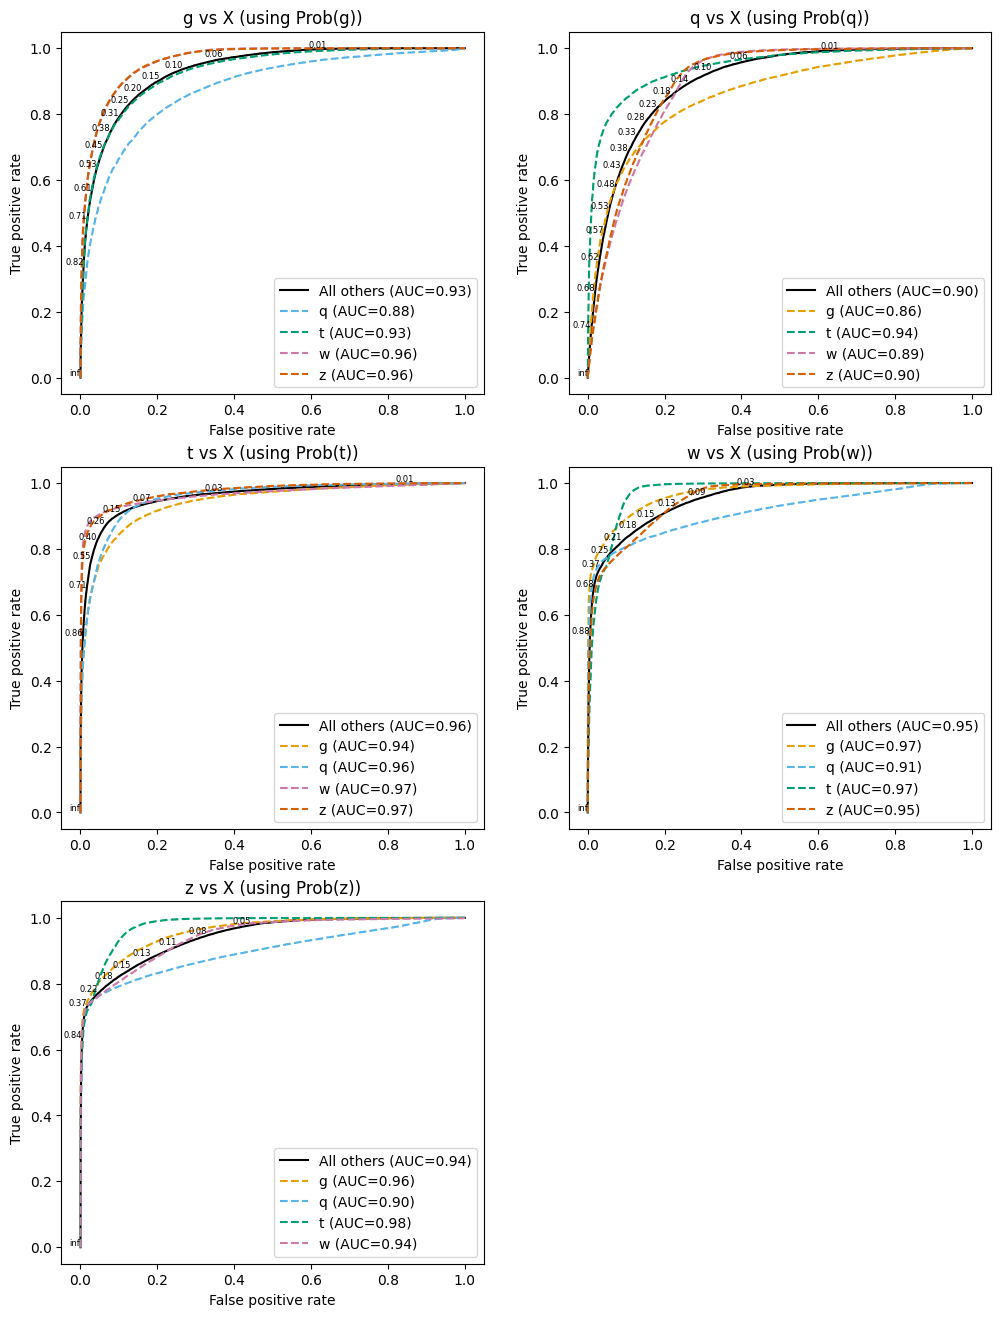

In [96]:
# SOLUTION 2)
from sklearn.metrics import roc_curve, roc_auc_score

fig, axs = plt.subplots(3,2, figsize=(12,16))
axs[2,1].axis('off')

for j, label in enumerate(list(labels)):

    x = int(np.floor(j/2))
    y = j%2

    y_true = masks[label]
    y_pred = probs[label]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    axs[x][y].plot(fpr, tpr, label=f"All others (AUC={auc:.2f})", color='black')
    for i in range(0, len(thresholds), 2000):
        axs[x][y].text(fpr[i], tpr[i], f"{thresholds[i]:.2f}", fontsize=6, ha='right', va='bottom', color='black')

    # Plot for each pair
    for other_label in labels:
        if other_label == label:
            continue

        mask_pair = masks[label]+masks[other_label]
        fpr, tpr, thresholds = roc_curve(y_true[mask_pair], y_pred[mask_pair])
        auc = roc_auc_score(y_true[mask_pair], y_pred[mask_pair])
        axs[x][y].plot(fpr, tpr, label=f"{other_label} (AUC={auc:.2f})", color=colors[np.where(labels==other_label)[0][0]], ls='--')

    axs[x][y].set_xlabel("False positive rate")
    axs[x][y].set_ylabel("True positive rate")
    axs[x][y].set_title(f"{label} vs X (using Prob({label}))")
    axs[x][y].legend(loc='lower right')

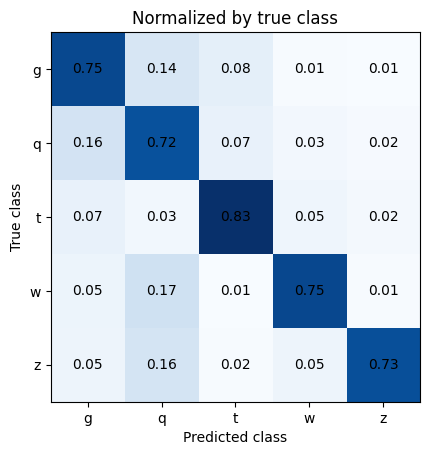

In [112]:
# SOLUTION: 3) This tell us the fraction of each true class landing in each predicted class
from sklearn.metrics import confusion_matrix

y_true_label = np.argmax(y_test, axis=1)
y_pred_label = np.argmax(y_keras, axis=1)

cm = confusion_matrix(y_true_label, y_pred_label, normalize='true')

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')
ax.set_title("Normalized by true class")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='black')

<div style="background-color:#FFE5CC">

### Questions

Do you understand what each of these plots are showing?

* Which true class is most often misidentified as a gluon-jet (g)?
* What do the small numbers in the ROC curves represent?
* Which true class is easiest to identify?

## Part 3: Online jet-tagging -- convert the model to FPGA firmware

As discussed in the lectures, we will benefit hugely from implementing Machine Learning in the CMS trigger - the part of the detector that decides which data should be read to disk. For this "online" jet tagging, we need to synthesize the neural network classifier trained in the previous section into FPGA firmware, and ensure that it fits with the latency and resource usage requirements.

In this section we will convert the neural network trained with tensorflow into FPGA firmware. This is known as High-Level Synthesis (HLS) which allows us to write software-like code (e.g. in C, C++) and automatically compile it into hardware code (logic gates, registers, interconnects) that can be synthesized on an FPGA.

This tutorial uses the `hls4ml` package with an Intel OneAPI backend to do this. **TODO** Add some information here about hls4ml and OneAPI. Explain other approaches and limitations of this approach i.e. can't go all the way to synthesis.

Before starting, there's one key property of HLS which must be discussed...

### Datatypes in HLS
Fixed point representation is used instead of floating point. For example the `hls4ml` default `fixed<16,6>` corresponds to:
```
+-------------------------+---------------------------+
|  Integer part (6 bits)  | Fractional part (10 bits) |
+-------------------------+---------------------------+
| 101010                  |                1010101010 |
+-------------------------+---------------------------+
|           Full bitwidth (16 bits)                   |
+-------------------------+---------------------------+
```
**TODO** Add some more discussion here.

Read more: https://github.com/hlslibs/ac_types/blob/v3.7/pdfdocs/ac_datatypes_ref.pdf

This has important consequences for the models to be synthesized. We will even look at how we can incorporate the bitwidths into the training process to maximize accuracy (see Part 4).

Let's set up the converter:

In [11]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='oneAPI')
print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Configu

What do the different items in the configuration dictionary correspond to? The most important for you to understand are:

* `Precision`: specifies the numeric format to use in the generated hardware. This choice affects both resource usage and model accuracy. The precision can be specified globally (as shown above) or separate for each neural network layer.
* `ReuseFactor`: controls hardware reuse, such that `1` means no reuse i.e. the design uses as many hardware resources as needed to execute all operations in parallel. The lower this factor the faster the inference (lower latency) but more FPGA area (i.e. resources) is used
* `Strategy`: tells hls4ml to optimize for the lowest possible latency. Other strategies include `Resource`, which optimizes for minimal area.

We will now convert the keras model we trained for an Intel "Agilex7" FPGA, a family of high-end FPGAs which are designed for performance-demanding and power-efficient applications, like AI acceleration. This may take a minute or so.

In [12]:
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='oneAPI', output_dir='model_1/hls4ml_prj', part='Agilex7'
)
hls_model.compile()

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model
Writing HLS project
Done
/opt/intel/oneapi/2025.0/bin/icpx
-- Configuring the design to run on FPGA board Ag

Now that we have converted the model, we can evaluate the accuracy. This should show little change from the software model.

In [13]:
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

hls_accuracy = np.sum(np.argmax(y_test, axis=1) == np.argmax(y_hls, axis=1))/y_test.shape[0]

In [14]:
print(f"Achieved test accuracy of {(100 * hls_accuracy):.2f}%")

Achieved test accuracy of 75.51%


### Create a report of the FPGA resource usage

Now that we have a classifier which has been converted (and compiled) for use on an FPGA, we can emulate the design build and estimate the resource usage to see if it is compatible with out resource requirements. The report is produced in the project directory. We will will print out the key information from the build report.
* **Note**: ignore the seg fault

In [15]:
hls_model.build(build_type='report')

/opt/intel/oneapi/2025.0/bin/icpx
-- Configuring the design to run on FPGA board Agilex7
-- Additional USER_FPGA_FLAGS=-Wno-unused-label
-- Additional USER_FLAGS=-Wno-unused-label;-fconstexpr-steps=134217728
-- Additional USER_INCLUDE_PATHS=src;src/firmware
-- Additional USER_LIB_PATHS=
-- Additional USER_LIBS=
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/jlangfor/local/Imperial/ICRF/teaching/AIMS25/hls4ml-aims2025/model_1/hls4ml_prj/build
[ 25%] To compile manually:
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/firmware/myproject.cpp -o CMakeFiles/report.dir/src/firmware/myproject.cpp.o
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/myproject_test.cpp -o CMakeFiles/report.dir/src/myproject_test.c

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report


{'report': {'HLS': {'total': {'alut': 128249,
    'reg': 140619,
    'ram': 8,
    'dsp': 17,
    'mlab': 18},
   'available': {'alut': '974400',
    'reg': '1948800',
    'ram': '7110',
    'dsp': '4510',
    'mlab': '24360'}},
  'Loop': {'worstFrequency': '480.0',
   'worstII': '1',
   'worstLatency': '215.0'}}}

In [16]:
with open("model_1/hls4ml_prj/build/myproject.report.prj/reports/resources/json/summary.ndjson", "r") as f:
    summary = ndjson.load(f)

resource_names = list(filter(lambda x: x["name"] == "Estimated Resource Usage", summary))[0]['columns'][1:-1]
available = list(filter(lambda x: x["name"] == "Available", summary))[0]['data'][:-1]
estimated_resources = list(filter(lambda x: x["name"] == "Total", summary))[0]['data'][:-1]

print("~~~~~~~~~~~~~~ Resource usage ~~~~~~~~~~~~~~")
for i, resource in enumerate(resource_names):
    print(f"--> {resource}:")
    print(f"      * Available resource: {available[i]}")
    print(f"      * Used resource (estimated): {estimated_resources[i]}")
    print(f"      * Percentage of used resource (estimated): {100*float(estimated_resources[i])/float(available[i]):.2f}%")

~~~~~~~~~~~~~~ Resource usage ~~~~~~~~~~~~~~
--> ALUTs :
      * Available resource: 974400
      * Used resource (estimated): 128249
      * Percentage of used resource (estimated): 13.16%
--> FFs  :
      * Available resource: 1948800
      * Used resource (estimated): 140619
      * Percentage of used resource (estimated): 7.22%
--> RAMs :
      * Available resource: 7110
      * Used resource (estimated): 8
      * Percentage of used resource (estimated): 0.11%
--> DSPs :
      * Available resource: 4510
      * Used resource (estimated): 17
      * Percentage of used resource (estimated): 0.38%
--> MLABs:
      * Available resource: 24360
      * Used resource (estimated): 18
      * Percentage of used resource (estimated): 0.07%


The different resource types correspond to:
* ALUTs: adaptive look-up tables. Implement logic expressions/functions
* FFs: flip-flops. Store one bit of data; used for variables/registers
* RAMs: On-chip block RAMs. Used for storing network weights, activations etc.
* DSPs: Digital Signal Processing blocks. Optimized for multiply/add functionalities which are ideal for NN layers.
* MLABs: Memory Logic Array blocks. Small, distributed memory with lower latency and smaller capacity than RAMs.

A simple (reductive) guide for when compiling a neural network with hls4ml. If it uses:
* Many DSPs --> You are doing lots of multiple/add operations e.g. dense layers/convolutions
* Lots of RAMs/MLABs --> You are storing many activations, weights, or intermediate values.
* High ALUT/FF usage --> Your logic is complex e.g. control flow, state machines.

So even a quite simple neural network design (only ~3000 trainable parameters) can take up a sizeable chunk of the FPGA. 
* How can we accelerate more complex ML algorithms without being limited by the resources?
* How can we store many ML algorithms on the same FPGA?

We need to think smarter in terms of the training!

<div style="background-color:#C2F5DD">
    
### Exercise

Now you have learnt how to convert a software neural network into FPGA firmware, let's see how changing the bitwidth affects the accuracy as well as resource usage.

Your task is to loop over several bitwidths and plot the accuracy and resource usage as a function of bitwidth. 

</div>

In [19]:
# SOLUTION: you can base your solution using the skeleton code below
# We will fix the number of integer bits at 6, use the rest for fractional component

# Loop over a set of bit widths
bit_widths = [8, 10, 12, 14, 16, 18, 20]

hls_accuracy_list = []
hls_summary_list = []

for bit_width in bit_widths:
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f" --> Testing bit width: {bit_width}")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    # Set default bit_width in the config
    config_tmp = config
    config_tmp['Model']['Precision']['default'] = f"fixed<{bit_width},6>"

    # Convert and compile the model
    hls_model = hls4ml.converters.convert_from_keras_model(
        model, hls_config=config_tmp, backend='oneAPI', output_dir='model_tmp/hls4ml_prj', part='Agilex7'
    )
    hls_model.compile()

    # Evaluate the accuracy of the model
    X_test = np.ascontiguousarray(X_test)
    y_hls = hls_model.predict(X_test)
    accuracy = np.sum(np.argmax(y_test, axis=1) == np.argmax(y_hls, axis=1))/y_test.shape[0]
    hls_accuracy_list.append(accuracy)

    # Emulate the build and evaluate the resource usage
    hls_model.build(build_type='report')
    with open("model_tmp/hls4ml_prj/build/myproject.report.prj/reports/resources/json/summary.ndjson", "r") as f:
        summary = ndjson.load(f)
    hls_summary_list.append(summary)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> Testing bit width: 8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model


icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> Testing bit width: 10
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> Testing bit width: 12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> Testing bit width: 14
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> Testing bit width: 16
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> Testing bit width: 18
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> Testing bit width: 20
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report


In [20]:
# SOLUTION: Extract resource usage from summary jsons
resource_usage = {}
for summ in hls_summary_list:
    resource_names = list(filter(lambda x: x["name"] == "Estimated Resource Usage", summ))[0]['columns'][1:-1]
    available = list(filter(lambda x: x["name"] == "Available", summ))[0]['data'][:-1]
    estimated_resources = list(filter(lambda x: x["name"] == "Total", summ))[0]['data'][:-1]

    for i, resource in enumerate(resource_names):
        r = resource.split(" ")[0]
        if r not in resource_usage:
            resource_usage[r] = [float(estimated_resources[i])/float(available[i])]
        else:
            resource_usage[r].append(float(estimated_resources[i])/float(available[i]))

Text(0, 0.5, 'MLABs [%]')

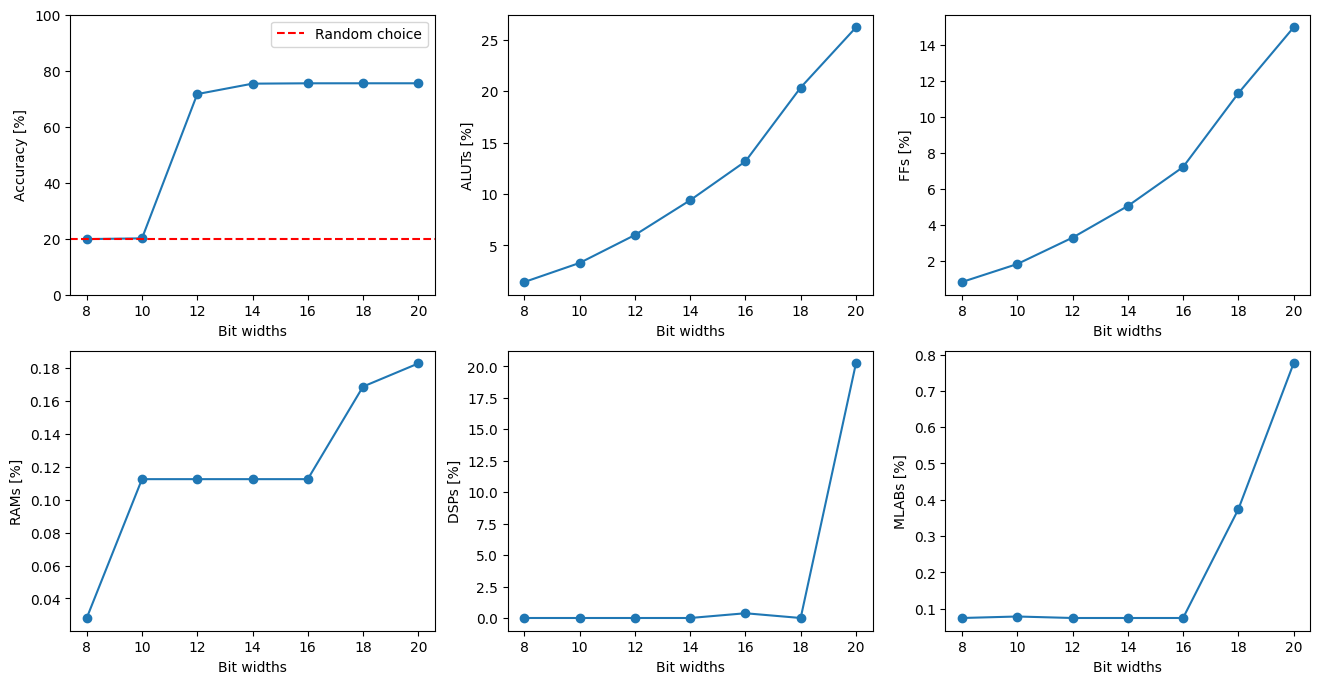

In [21]:
# SOLUTION: Plot accuracy and resource usage as a function of the bit widths
fig, axs = plt.subplots(2,3, figsize=(16,8))

# Top left: accuracy
axs[0][0].plot(bit_widths, 100*np.array(hls_accuracy_list), marker='o')
axs[0][0].set_xlabel("Bit widths")
axs[0][0].set_ylabel("Accuracy [%]")
axs[0][0].axhline(20, color='red', ls='--', label="Random choice")
axs[0][0].set_ylim(0,100)
axs[0][0].legend(loc='best')

# Top middle: ALUT usage
axs[0][1].plot(bit_widths, 100*np.array(resource_usage['ALUTs']), marker='o')
axs[0][1].set_xlabel("Bit widths")
axs[0][1].set_ylabel("ALUTs [%]")

# Top right: FF usage
axs[0][2].plot(bit_widths, 100*np.array(resource_usage['FFs']), marker='o')
axs[0][2].set_xlabel("Bit widths")
axs[0][2].set_ylabel("FFs [%]")

# Bottom left: accuracy
axs[1][0].plot(bit_widths, 100*np.array(resource_usage['RAMs']), marker='o')
axs[1][0].set_xlabel("Bit widths")
axs[1][0].set_ylabel("RAMs [%]")

# Top middle: ALUT usage
axs[1][1].plot(bit_widths, 100*np.array(resource_usage['DSPs']), marker='o')
axs[1][1].set_xlabel("Bit widths")
axs[1][1].set_ylabel("DSPs [%]")

# Top right: FF usage
axs[1][2].plot(bit_widths, 100*np.array(resource_usage['MLABs']), marker='o')
axs[1][2].set_xlabel("Bit widths")
axs[1][2].set_ylabel("MLABs [%]")

## Part 4: Quantization-Aware Training

In the previous exercise we have seen the trade-off between accuracy and resource usage.

As discussed in the lecture slides, we can achieve similar levels of accuracy with significantly lower bit widths by **quantizing** during the training. We will use the QKeras library to emulate fixed-point quantization during the forward pass of the training process. This ensures that network learns to optimally classify the different jet types within the fixed bit width budget.

By lowering the bit widths we can:
* Reduce the resource usage (lower memory footprint)
* Speed up the inference process (reduce latency)

These are essential for AI acceleration using FPGAs! Let's start by importing the `qkeras` library. We will then look at how the `quantized_bit` behaves vs the full floating point equivalent.

In [114]:
import qkeras
from qkeras import QDense
from qkeras.quantizers import quantized_bits

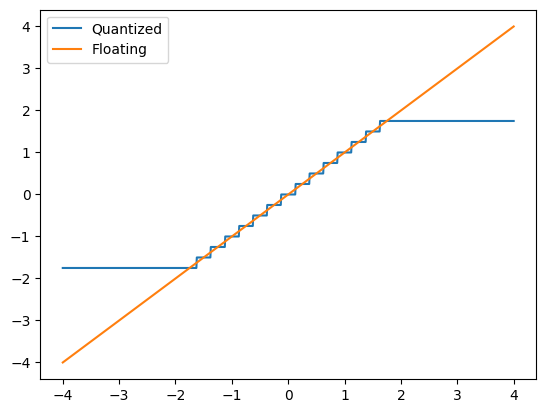

In [115]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-4,4,1000), quantized_bits(4,1,1,alpha=1)(np.linspace(-4,4,1000)))
ax.plot(np.linspace(-4,4,1000), np.linspace(-4,4,1000))

ax.legend(["Quantized", "Floating"])

<div style="background-color:#FFE5CC">

### Questions
* Do you understand what the plot is showing?

### Creating a quantized model

To create a "quantized" neural network we using the `QDense` layer. This requires setting the `kernel_quantizer` and `bias_quantizer`, which control how the layer's weights and biases are quantized, respectively i.e. how they are converted from full-precision floating-point numbers to lower-bit fixed-point formats during training and inference.

We will reduce the model size substantially by only using 4 bits (1 integer) for each weight and bias in the network. This means each weight and bias can only take 1 of 16 different values (as shown in the plot above). Note, the number of training parameters does not change.

In [116]:
qmodel = Sequential()
qmodel.add(QDense(32, input_shape=(16,),
                  name='fc1',
                  kernel_quantizer = quantized_bits(4,1,1,alpha=1),
                  bias_quantizer = quantized_bits(4,1,1,alpha=1),
                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
qmodel.add(Activation(activation='relu', name='relu1'))
qmodel.add(QDense(32, 
                  name='fc2', 
                  kernel_quantizer = quantized_bits(4,1,1,alpha=1),
                  bias_quantizer = quantized_bits(4,1,1,alpha=1),                  
                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
qmodel.add(Activation(activation='relu', name='relu2'))
qmodel.add(QDense(32, 
                  name='fc3', 
                  kernel_quantizer = quantized_bits(4,1,1,alpha=1),
                  bias_quantizer = quantized_bits(4,1,1,alpha=1),                  
                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
qmodel.add(Activation(activation='relu', name='relu3'))
qmodel.add(QDense(5, 
                  name='output', 
                  kernel_quantizer = quantized_bits(4,1,1,alpha=1),
                  bias_quantizer = quantized_bits(4,1,1,alpha=1),                  
                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
qmodel.add(Activation(activation='softmax', name='softmax'))

qmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 32)                544       
                                                                 
 relu1 (Activation)          (None, 32)                0         
                                                                 
 fc2 (QDense)                (None, 32)                1056      
                                                                 
 relu2 (Activation)          (None, 32)                0         
                                                                 
 fc3 (QDense)                (None, 32)                1056      
                                                                 
 relu3 (Activation)          (None, 32)                0         
                                                                 
 output (QDense)             (None, 5)                

Now let's train the network. With qkeras the fixed-point format is only used for the forward pass, and we revert back to the floating-point format for the backwards pass (backpropagation). This ensures that the loss is smooth and differentiable, with respect to the network weights and biases.

In [117]:
adam = Adam(learning_rate=0.0001)
qmodel.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

# We will initialise with the weights from the full floating-points model (translated into the quantized_bit format)
qmodel.set_weights(model.get_weights())

In [118]:
N_epochs = 20
result_qkeras = qmodel.fit(
    X_train_val,
    y_train_val,
    batch_size=128,
    epochs=N_epochs,
    validation_split=0.25,
    shuffle=True,
)

Epoch 1/20
3891/3891 [==============================] - 10s 2ms/step - loss: 0.7870 - accuracy: 0.7390 - val_loss: 0.7773 - val_accuracy: 0.7421
Epoch 2/20
3891/3891 [==============================] - 7s 2ms/step - loss: 0.7785 - accuracy: 0.7393 - val_loss: 0.8302 - val_accuracy: 0.7164
Epoch 3/20
3891/3891 [==============================] - 7s 2ms/step - loss: 0.7769 - accuracy: 0.7402 - val_loss: 0.7785 - val_accuracy: 0.7374
Epoch 4/20
3891/3891 [==============================] - 6s 2ms/step - loss: 0.7728 - accuracy: 0.7415 - val_loss: 0.7712 - val_accuracy: 0.7457
Epoch 5/20
3891/3891 [==============================] - 7s 2ms/step - loss: 0.7700 - accuracy: 0.7421 - val_loss: 0.7857 - val_accuracy: 0.7355
Epoch 6/20
3891/3891 [==============================] - 6s 2ms/step - loss: 0.7677 - accuracy: 0.7432 - val_loss: 0.7552 - val_accuracy: 0.7457
Epoch 7/20
3891/3891 [==============================] - 6s 2ms/step - loss: 0.7669 - accuracy: 0.7429 - val_loss: 0.7549 - val_accuracy

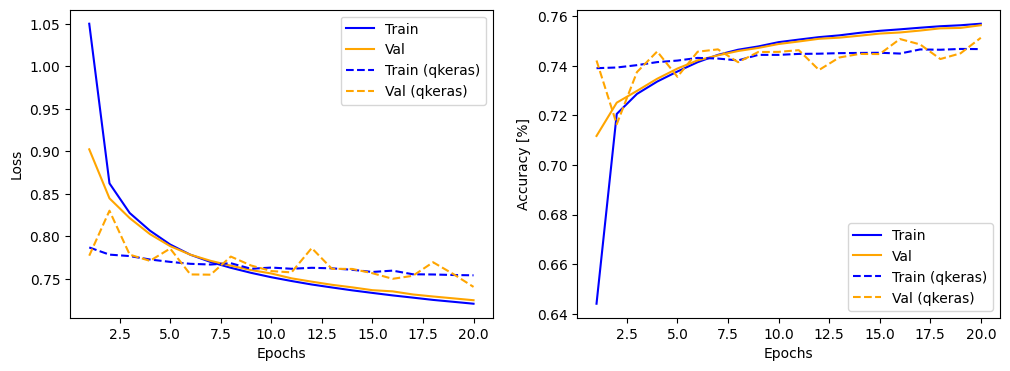

In [119]:
# Plot the training history and compare to the normal keras training
history_qkeras = result_qkeras.history

fig, axs = plt.subplots(1,2, figsize=(12,4))

epochs = np.linspace(1, N_epochs, N_epochs)
axs[0].plot(epochs, history['loss'], c='blue', label='Train')
axs[0].plot(epochs, history['val_loss'], c='orange', label='Val')
axs[0].plot(epochs, history_qkeras['loss'], c='blue', label='Train (qkeras)', ls='--')
axs[0].plot(epochs, history_qkeras['val_loss'], c='orange', label='Val (qkeras)', ls='--')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(loc='upper right')

axs[1].plot(epochs, history['accuracy'], c='blue', label='Train')
axs[1].plot(epochs, history['val_accuracy'], c='orange', label='Val')
axs[1].plot(epochs, history_qkeras['accuracy'], c='blue', label='Train (qkeras)', ls='--')
axs[1].plot(epochs, history_qkeras['val_accuracy'], c='orange', label='Val (qkeras)', ls='--')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy [%]")
axs[1].legend(loc='lower right')

<div style="background-color:#FFE5CC">

### Questions
* What conclusions would you draw by comparing the loss curves?

Now we can use the hls4ml package to convert the "quantized" network into FPGA firmware via HLS. The key difference is that we are now using a more complex configuration, with a separate config per layer name. For this we need to set the `granularity` argument to `"name"`. Let's set up the configuration and look at the contents (ignoring the warning):

In [120]:
config = hls4ml.utils.config_from_keras_model(qmodel, granularity='name', backend='oneAPI')
print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Configuration
{'Model': {'Precision': {'default': 'fixed<16,6>'}, 'ReuseFactor': 1, 'St

/home/jlangfor/miniconda3/envs/oneapi-env/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


<div style="background-color:#FFE5CC">

### Questions
* Do you understand what has changed in the configuration for this "quantization-aware" network?

In [121]:
# Let's do the HLS conversion
hls_model = hls4ml.converters.convert_from_keras_model(
    qmodel, hls_config=config, backend='oneAPI', output_dir='model_2/hls4ml_prj', part='Agilex7'
)
hls_model.compile()

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model
Writing HLS project
Done
/opt/intel/oneapi/2025.0/bin/icpx
-- Configuring the design to run on FPGA boar

In [122]:
# And evaluate the accuracy on the data set
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

hls_accuracy = np.sum(np.argmax(y_test, axis=1) == np.argmax(y_hls, axis=1))/y_test.shape[0]

In [123]:
print(f"Achieved test accuracy of {(100 * hls_accuracy):.2f}%")

Achieved test accuracy of 75.11%


So we have managed to achieve roughly the same accuracy as the baseline model with much lower bit-widths.

Let's build the QKeras trained model and get an estimate for the resource usage.

In [124]:
hls_model.build(build_type='report')

/opt/intel/oneapi/2025.0/bin/icpx
-- Configuring the design to run on FPGA board Agilex7
-- Additional USER_FPGA_FLAGS=-Wno-unused-label
-- Additional USER_FLAGS=-Wno-unused-label;-fconstexpr-steps=134217728
-- Additional USER_INCLUDE_PATHS=src;src/firmware
-- Additional USER_LIB_PATHS=
-- Additional USER_LIBS=
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/jlangfor/local/Imperial/ICRF/teaching/AIMS25/hls4ml-aims2025/model_2/hls4ml_prj/build
[ 25%] To compile manually:
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/firmware/myproject.cpp -o CMakeFiles/report.dir/src/firmware/myproject.cpp.o
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/myproject_test.cpp -o CMakeFiles/report.dir/src/myproject_test.c

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report


{'report': {'HLS': {'total': {'alut': 31577,
    'reg': 36607,
    'ram': 8,
    'dsp': 0,
    'mlab': 22},
   'available': {'alut': '974400',
    'reg': '1948800',
    'ram': '7110',
    'dsp': '4510',
    'mlab': '24360'}},
  'Loop': {'worstFrequency': '480.0',
   'worstII': '1',
   'worstLatency': '207.0'}}}

In [128]:
with open("model_2/hls4ml_prj/build/myproject.report.prj/reports/resources/json/summary.ndjson", "r") as f:
    summary = ndjson.load(f)

resource_names = list(filter(lambda x: x["name"] == "Estimated Resource Usage", summary))[0]['columns'][1:-1]
available = list(filter(lambda x: x["name"] == "Available", summary))[0]['data'][:-1]
estimated_resources = list(filter(lambda x: x["name"] == "Total", summary))[0]['data'][:-1]

print("~~~~~~~~~~~~~~ Resource usage ~~~~~~~~~~~~~~")
for i, resource in enumerate(resource_names):
    print(f"--> {resource}:")
    print(f"      * Available resource: {available[i]}")
    print(f"      * Used resource (estimated): {estimated_resources[i]}")
    print(f"      * Percentage of used resource (estimated): {100*float(estimated_resources[i])/float(available[i]):.2f}%")

resource_usage_qkeras = {}
for i,resource in enumerate(resource_names):
    r = resource.split(" ")[0]
    resource_usage_qkeras[r] = float(estimated_resources[i])/float(available[i])

~~~~~~~~~~~~~~ Resource usage ~~~~~~~~~~~~~~
--> ALUTs :
      * Available resource: 974400
      * Used resource (estimated): 31577
      * Percentage of used resource (estimated): 3.24%
--> FFs  :
      * Available resource: 1948800
      * Used resource (estimated): 36607
      * Percentage of used resource (estimated): 1.88%
--> RAMs :
      * Available resource: 7110
      * Used resource (estimated): 8
      * Percentage of used resource (estimated): 0.11%
--> DSPs :
      * Available resource: 4510
      * Used resource (estimated): 0
      * Percentage of used resource (estimated): 0.00%
--> MLABs:
      * Available resource: 24360
      * Used resource (estimated): 22
      * Percentage of used resource (estimated): 0.09%


<div style="background-color:#C2F5DD">
    
### Exercise: 

How do these resource usage numbers compare to the baseline model?

1) Plot the accuracy and resource usage statistics vs bit-widths for the baseline model (previous exercise), adding an extra point for the QKeras trained network
2) Plot the ALUTs/FFs usage vs accuracy for different bin-widths (previous exercise), and add the point from the QKeras training

What conclusions can be drawn?

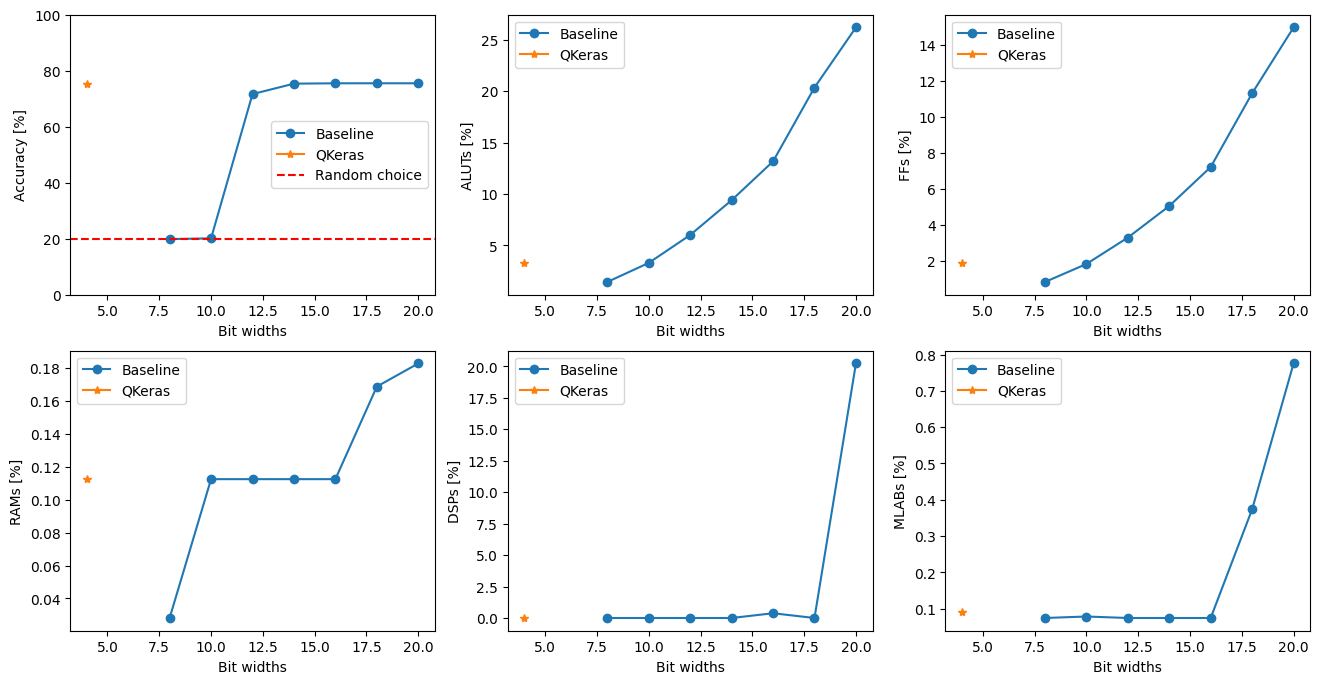

In [129]:
# SOLUTION 1)
fig, axs = plt.subplots(2,3, figsize=(16,8))

bit_width_qkeras = 4

# Top left: accuracy
axs[0][0].plot(bit_widths, 100*np.array(hls_accuracy_list), marker='o', label='Baseline')
axs[0][0].plot(bit_width_qkeras, 100*np.array(hls_accuracy), marker='*', label='QKeras')
axs[0][0].set_xlabel("Bit widths")
axs[0][0].set_ylabel("Accuracy [%]")
axs[0][0].axhline(20, color='red', ls='--', label="Random choice")
axs[0][0].set_ylim(0,100)
axs[0][0].legend(loc='best')

# Top middle: ALUT usage
axs[0][1].plot(bit_widths, 100*np.array(resource_usage['ALUTs']), marker='o', label='Baseline')
axs[0][1].plot(bit_width_qkeras, 100*resource_usage_qkeras['ALUTs'], marker='*', label='QKeras')
axs[0][1].set_xlabel("Bit widths")
axs[0][1].set_ylabel("ALUTs [%]")
axs[0][1].legend(loc='best')

# Top right: FF usage
axs[0][2].plot(bit_widths, 100*np.array(resource_usage['FFs']), marker='o', label='Baseline')
axs[0][2].plot(bit_width_qkeras, 100*resource_usage_qkeras['FFs'], marker='*', label='QKeras')
axs[0][2].set_xlabel("Bit widths")
axs[0][2].set_ylabel("FFs [%]")
axs[0][2].legend(loc='best')

# Bottom left: RAM usage
axs[1][0].plot(bit_widths, 100*np.array(resource_usage['RAMs']), marker='o', label='Baseline')
axs[1][0].plot(bit_width_qkeras, 100*resource_usage_qkeras['RAMs'], marker='*', label='QKeras')
axs[1][0].set_xlabel("Bit widths")
axs[1][0].set_ylabel("RAMs [%]")
axs[1][0].legend(loc='best')

# Top middle: DSP usage
axs[1][1].plot(bit_widths, 100*np.array(resource_usage['DSPs']), marker='o', label='Baseline')
axs[1][1].plot(bit_width_qkeras, 100*resource_usage_qkeras['DSPs'], marker='*', label='QKeras')
axs[1][1].set_xlabel("Bit widths")
axs[1][1].set_ylabel("DSPs [%]")
axs[1][1].legend(loc='best')

# Top right: MLAB usage
axs[1][2].plot(bit_widths, 100*np.array(resource_usage['MLABs']), marker='o', label='Baseline')
axs[1][2].plot(bit_width_qkeras, 100*resource_usage_qkeras['MLABs'], marker='*', label='QKeras')
axs[1][2].set_xlabel("Bit widths")
axs[1][2].set_ylabel("MLABs [%]")
axs[1][2].legend(loc='best')

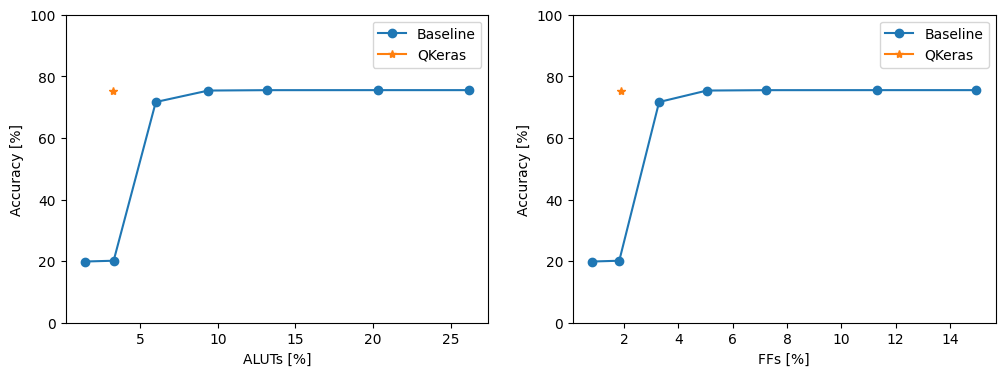

In [130]:
# SOLUTION 2)
# Plot ALUT usage vs accuracy
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(100*np.array(resource_usage['ALUTs']), 100*np.array(hls_accuracy_list), marker='o', label='Baseline')
axs[0].plot(100*resource_usage_qkeras['ALUTs'], 100*np.array(hls_accuracy), marker='*', label='QKeras')
axs[0].set_xlabel("ALUTs [%]")
axs[0].set_ylabel("Accuracy [%]")
axs[0].set_ylim(0,100)
axs[0].legend(loc='best')

# Plot ALUT usage vs accuracy
axs[1].plot(100*np.array(resource_usage['FFs']), 100*np.array(hls_accuracy_list), marker='o', label='Baseline')
axs[1].plot(100*resource_usage_qkeras['FFs'], 100*np.array(hls_accuracy), marker='*', label='QKeras')
axs[1].set_xlabel("FFs [%]")
axs[1].set_ylabel("Accuracy [%]")
axs[1].set_ylim(0,100)
axs[1].legend(loc='best')

This is a great achievement! We have obtained a classifier with the same performance for much smaller resource usage. These "tricks" have a huge consequence for accelerated artificial intelligence. Not only can we vastly speed-up the inference task (e.g. for use in low latency environments like the CMS level-1 trigger), but we can substantially reduce the carbon footprint involved in the inference. This will become increasingly important in an AI-dominated world.

<div style="background-color:#C2F5DD">

### Exercise

With the quantised-aware training, investigate how low we can take the bitwidth to still achieve the same accuracy as the baseline model.

Loop over several bitwidths and plot the accuracy and resource-usage as a function of bitwidth.

The following block of code, plots the fixed-point vs floating-point comparison for different bitwidths to visualise the problem. 

You will then need to loop over different bit widths and retrain the network to see what performance can be achieved. Note, the notation for bit width is: <total number of bits, number of integer bits>.

</div>

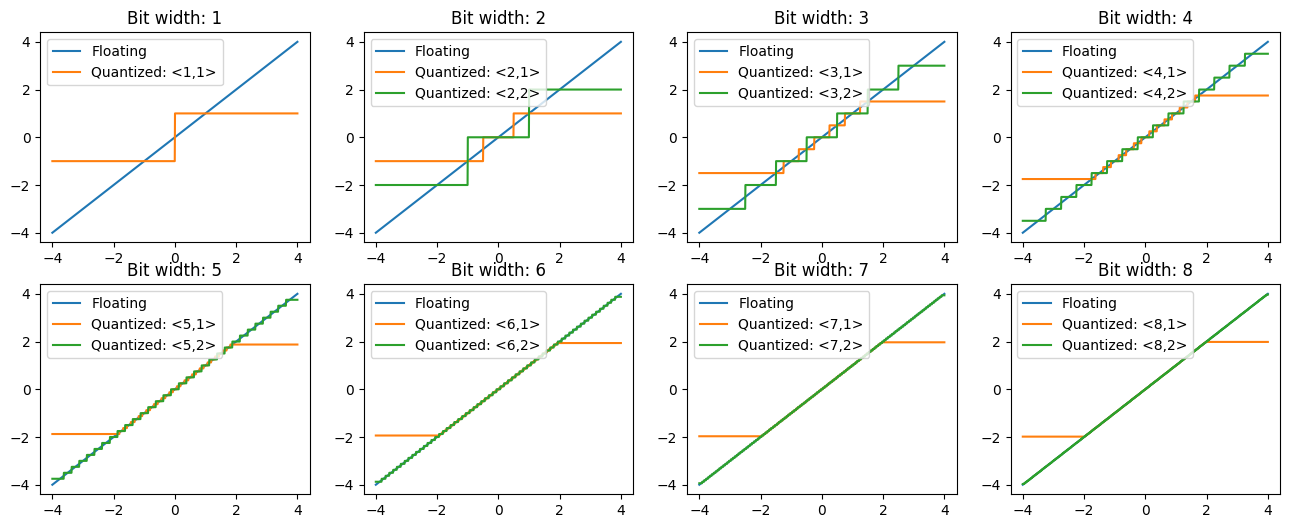

In [132]:
fig, axs = plt.subplots(2,4, figsize=(16,6))

for i in range(0,8):
    x = 0 if i < 4 else 1
    y = i % 4

    axs[x][y].plot(np.linspace(-4,4,1000), np.linspace(-4,4,1000))
    axs[x][y].plot(np.linspace(-4,4,1000), quantized_bits(i+1,1,1,alpha=1)(np.linspace(-4,4,1000)))
    if i > 0:
        axs[x][y].plot(np.linspace(-4,4,1000), quantized_bits(i+1,2,1,alpha=1)(np.linspace(-4,4,1000)))
    
    axs[x][y].set_title(f"Bit width: {i+1}")
    if i == 0:
        axs[x][y].legend(["Floating", "Quantized: <1,1>"])
    else:
        axs[x][y].legend(["Floating", f"Quantized: <{i+1},1>", f"Quantized: <{i+1},2>"])

In [133]:
# SOLUTION: you can base your solution using the skeleton code below
# We will keep the integer bit fixed at 1 (remaining bits are for fractional component)
bit_widths_qkeras = [1, 2, 3, 4, 5, 6]
N_epochs = 2

hls_accuracy_qkeras_list = []
hls_summary_qkeras_list = []

for bit_width in bit_widths_qkeras:
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f" --> QKeras model with bit width: {bit_width}")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

    # Build the QKeras model, setting the first argument in the quantized_bits function to bit_width
    qmodel = Sequential()
    qmodel.add(QDense(32, input_shape=(16,),
                  name='fc1',
                  kernel_quantizer = quantized_bits(bit_width,1,1,alpha=1),
                  bias_quantizer = quantized_bits(bit_width,1,1,alpha=1),
                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
    qmodel.add(Activation(activation='relu', name='relu1'))
    qmodel.add(QDense(32, 
                  name='fc2', 
                  kernel_quantizer = quantized_bits(bit_width,1,1,alpha=1),
                  bias_quantizer = quantized_bits(bit_width,1,1,alpha=1),                  
                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
    qmodel.add(Activation(activation='relu', name='relu2'))
    qmodel.add(QDense(32, 
                  name='fc3', 
                  kernel_quantizer = quantized_bits(bit_width,1,1,alpha=1),
                  bias_quantizer = quantized_bits(bit_width,1,1,alpha=1),                  
                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
    qmodel.add(Activation(activation='relu', name='relu3'))
    qmodel.add(QDense(5, 
                  name='output', 
                  kernel_quantizer = quantized_bits(bit_width,1,1,alpha=1),
                  bias_quantizer = quantized_bits(bit_width,1,1,alpha=1),                  
                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
    qmodel.add(Activation(activation='softmax', name='softmax'))

    # Initiate the optimiser, compile the QKeras model, and initiate the weights according to the baseline model
    adam = Adam(learning_rate=0.0001)
    qmodel.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    qmodel.set_weights(model.get_weights())

    # Train for small number of epochs (=2)
    result_qkeras = qmodel.fit(
        X_train_val,
        y_train_val,
        batch_size=128,
        epochs=N_epochs,
        validation_split=0.25,
        shuffle=True,
    )

    # Build the hls4ml config from the trained model, using granularity="name"
    config = hls4ml.utils.config_from_keras_model(qmodel, granularity='name', backend='oneAPI')

    # Convert and compile the model
    hls_model = hls4ml.converters.convert_from_keras_model(
        qmodel, hls_config=config, backend='oneAPI', output_dir='model_qtmp/hls4ml_prj', part='Agilex7'
    )
    hls_model.compile()

    # Calculate the accuracy and store it
    X_test = np.ascontiguousarray(X_test)
    y_hls = hls_model.predict(X_test)
    accuracy = np.sum(np.argmax(y_test, axis=1) == np.argmax(y_hls, axis=1))/y_test.shape[0]
    hls_accuracy_qkeras_list.append(accuracy)

    # Emulate the build and store the resource usage summary
    hls_model.build(build_type='report')
    with open("model_qtmp/hls4ml_prj/build/myproject.report.prj/reports/resources/json/summary.ndjson", "r") as f:
        summary = ndjson.load(f)
    hls_summary_qkeras_list.append(summary)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> QKeras model with bit width: 1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


/home/jlangfor/miniconda3/envs/oneapi-env/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer LecunUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/2
3891/3891 [==============================] - 9s 2ms/step - loss: 24.0764 - accuracy: 0.4398 - val_loss: 2.4311 - val_accuracy: 0.3014
Epoch 2/2
3891/3891 [==============================] - 5s 1ms/step - loss: 1.7584 - accuracy: 0.2263 - val_loss: 1.7313 - val_accuracy: 0.2013
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, l

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> QKeras model with bit width: 2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/2
3891/3891 [==============================] - 7s 2ms/step - loss: 1.5524 - accuracy: 0.2489 - val_loss: 1.6149 - val_accuracy: 0.2013
Epoch 2/2
3891/3891 [==============================] - 8s 2ms/step - loss: 1.6126 - accuracy: 0.2014 - val_loss: 1.6113 - val_accuracy: 0.2013
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input 

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> QKeras model with bit width: 3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/2
3891/3891 [==============================] - 8s 2ms/step - loss: 0.9081 - accuracy: 0.7011 - val_loss: 0.8511 - val_accuracy: 0.7203
Epoch 2/2
3891/3891 [==============================] - 7s 2ms/step - loss: 0.8452 - accuracy: 0.7179 - val_loss: 0.8099 - val_accuracy: 0.7322
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input 

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> QKeras model with bit width: 4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/2
3891/3891 [==============================] - 8s 2ms/step - loss: 0.7870 - accuracy: 0.7390 - val_loss: 0.7773 - val_accuracy: 0.7421
Epoch 2/2
3891/3891 [==============================] - 8s 2ms/step - loss: 0.7785 - accuracy: 0.7393 - val_loss: 0.8302 - val_accuracy: 0.7164
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input 

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> QKeras model with bit width: 5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/2
3891/3891 [==============================] - 10s 2ms/step - loss: 0.7393 - accuracy: 0.7516 - val_loss: 0.7369 - val_accuracy: 0.7522
Epoch 2/2
3891/3891 [==============================] - 15s 4ms/step - loss: 0.7383 - accuracy: 0.7515 - val_loss: 0.7406 - val_accuracy: 0.7522
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, inpu

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> QKeras model with bit width: 6
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/2
3891/3891 [==============================] - 7s 2ms/step - loss: 0.7262 - accuracy: 0.7559 - val_loss: 0.7302 - val_accuracy: 0.7545
Epoch 2/2
3891/3891 [==============================] - 10s 2ms/step - loss: 0.7242 - accuracy: 0.7561 - val_loss: 0.7273 - val_accuracy: 0.7555
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report


In [134]:
# SOLUTION: extract resource usage from summary jsons
resource_usage_qkeras_list = {}
for summ in hls_summary_qkeras_list:
    resource_names = list(filter(lambda x: x["name"] == "Estimated Resource Usage", summ))[0]['columns'][1:-1]
    available = list(filter(lambda x: x["name"] == "Available", summ))[0]['data'][:-1]
    estimated_resources = list(filter(lambda x: x["name"] == "Total", summ))[0]['data'][:-1]

    for i, resource in enumerate(resource_names):
        r = resource.split(" ")[0]
        if r not in resource_usage_qkeras_list:
            resource_usage_qkeras_list[r] = [float(estimated_resources[i])/float(available[i])]
        else:
            resource_usage_qkeras_list[r].append(float(estimated_resources[i])/float(available[i]))

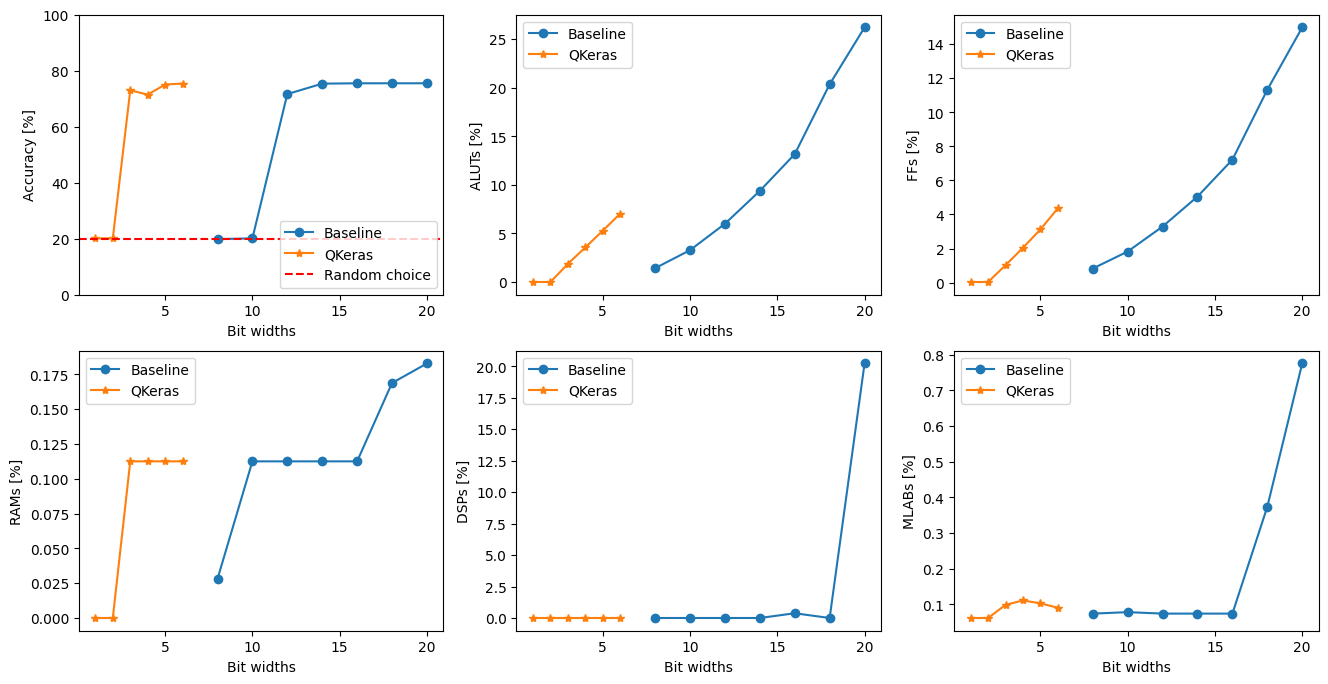

In [135]:
# SOLUTION: plot accuracy and resource-usage vs bit-width for baseline training and for QKeras training
fig, axs = plt.subplots(2,3, figsize=(16,8))

# Top left: accuracy
axs[0][0].plot(bit_widths, 100*np.array(hls_accuracy_list), marker='o', label='Baseline')
axs[0][0].plot(bit_widths_qkeras, 100*np.array(hls_accuracy_qkeras_list), marker='*', label='QKeras')
axs[0][0].set_xlabel("Bit widths")
axs[0][0].set_ylabel("Accuracy [%]")
axs[0][0].axhline(20, color='red', ls='--', label="Random choice")
axs[0][0].set_ylim(0,100)
axs[0][0].legend(loc='best')

# Top middle: ALUT usage
axs[0][1].plot(bit_widths, 100*np.array(resource_usage['ALUTs']), marker='o', label='Baseline')
axs[0][1].plot(bit_widths_qkeras, 100*np.array(resource_usage_qkeras_list['ALUTs']), marker='*', label='QKeras')
axs[0][1].set_xlabel("Bit widths")
axs[0][1].set_ylabel("ALUTs [%]")
axs[0][1].legend(loc='best')

# Top right: FF usage
axs[0][2].plot(bit_widths, 100*np.array(resource_usage['FFs']), marker='o', label='Baseline')
axs[0][2].plot(bit_widths_qkeras, 100*np.array(resource_usage_qkeras_list['FFs']), marker='*', label='QKeras')
axs[0][2].set_xlabel("Bit widths")
axs[0][2].set_ylabel("FFs [%]")
axs[0][2].legend(loc='best')

# Bottom left: RAM usage
axs[1][0].plot(bit_widths, 100*np.array(resource_usage['RAMs']), marker='o', label='Baseline')
axs[1][0].plot(bit_widths_qkeras, 100*np.array(resource_usage_qkeras_list['RAMs']), marker='*', label='QKeras')
axs[1][0].set_xlabel("Bit widths")
axs[1][0].set_ylabel("RAMs [%]")
axs[1][0].legend(loc='best')

# Top middle: DSP usage
axs[1][1].plot(bit_widths, 100*np.array(resource_usage['DSPs']), marker='o', label='Baseline')
axs[1][1].plot(bit_widths_qkeras, 100*np.array(resource_usage_qkeras_list['DSPs']), marker='*', label='QKeras')
axs[1][1].set_xlabel("Bit widths")
axs[1][1].set_ylabel("DSPs [%]")
axs[1][1].legend(loc='best')

# Top right: MLAB usage
axs[1][2].plot(bit_widths, 100*np.array(resource_usage['MLABs']), marker='o', label='Baseline')
axs[1][2].plot(bit_widths_qkeras, 100*np.array(resource_usage_qkeras_list['MLABs']), marker='*', label='QKeras')
axs[1][2].set_xlabel("Bit widths")
axs[1][2].set_ylabel("MLABs [%]")
axs[1][2].legend(loc='best')

<div style="background-color:#C2F5DD">

### Exercise

* Write a small summary paragraph (or a few bullet points) explaining the results you have obtained

## Part 5: Pruning

In this section we will discuss another method for reducing the resource usage, known as pruning.

Weight matrices in neural networks can be huge. However not every weight contributes equally to the model performance. Pruning removes the low magnitude weights with very small impact to the classification performance.

On FPGAs, the weight matrices are known at compile time. Weights that are zero can be omitted by the compiler which of course reduces resource usage. 

To obtain sparse weight matrices, we can use L1 regularization to reduce weight magnitude. Then pruning can be scheduled to incrementaly remove and mask low magnitude weights.

Let's first import the relevant functionalities from keras.

In [136]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

Now we will set the pruning parameters (sparsity = 75%) and prune the baseline model (without QKeras training)

In [137]:
pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=100, frequency=100)}
pmodel = prune.prune_low_magnitude(model, **pruning_params)

Let's then retrain the pruned network

In [138]:
adam = Adam(learning_rate=0.0001)
pmodel.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

pmodel.fit(
    X_train_val,
    y_train_val,
    batch_size=128,
    epochs=5,
    validation_split=0.25,
    shuffle=True,
    callbacks=[pruning_callbacks.UpdatePruningStep()],
)

Epoch 1/5
3891/3891 [==============================] - 9s 2ms/step - loss: 0.8538 - accuracy: 0.7114 - val_loss: 0.7736 - val_accuracy: 0.7383
Epoch 2/5
3891/3891 [==============================] - 6s 2ms/step - loss: 0.7582 - accuracy: 0.7432 - val_loss: 0.7533 - val_accuracy: 0.7444
Epoch 3/5
3891/3891 [==============================] - 7s 2ms/step - loss: 0.7440 - accuracy: 0.7467 - val_loss: 0.7434 - val_accuracy: 0.7466
Epoch 4/5
3891/3891 [==============================] - 11s 3ms/step - loss: 0.7364 - accuracy: 0.7486 - val_loss: 0.7372 - val_accuracy: 0.7486
Epoch 5/5
3891/3891 [==============================] - 13s 3ms/step - loss: 0.7312 - accuracy: 0.7499 - val_loss: 0.7331 - val_accuracy: 0.7498


In [139]:
# Strip pruning wrappers before converting for inference
pmodel = strip_pruning(pmodel)

In [140]:
# Print percentage sparsity (i.e. percentage of zero weights) for each layer
for i, l in zip(pmodel.get_weights(), pmodel.layers):
    print(f"{np.sum(i.flatten()==0)/i.flatten().shape[0]*100:.1f}% sparsity for layer {l.name}")

74.8% sparsity for layer fc1
0.0% sparsity for layer relu1
75.0% sparsity for layer fc2
0.0% sparsity for layer relu2
75.0% sparsity for layer fc3
0.0% sparsity for layer relu3
75.0% sparsity for layer output
0.0% sparsity for layer softmax


Now we have trained a pruned neural network with 75% of weights stripped (zero), that achieves roughly the same accuracy as the baseline model. To highlight the impact of this, we will convert the model to FPGA firmware using hls4ml, and examine the resource usage.

In [141]:
config = hls4ml.utils.config_from_keras_model(pmodel, granularity='model', backend='oneAPI')
print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    pmodel, hls_config=config, backend='oneAPI', output_dir='model_3/hls4ml_prj', part='Agilex7'
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Configuration
{'Model': {'Precision': {'default': 'fixed<16,6>'}, 'ReuseFactor': 1, 'Strate

In [142]:
hls_model.compile()

Writing HLS project
Done
/opt/intel/oneapi/2025.0/bin/icpx
-- Configuring the design to run on FPGA board Agilex7
-- Additional USER_FPGA_FLAGS=-Wno-unused-label
-- Additional USER_FLAGS=-Wno-unused-label;-fconstexpr-steps=134217728
-- Additional USER_INCLUDE_PATHS=src;src/firmware
-- Additional USER_LIB_PATHS=
-- Additional USER_LIBS=
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/jlangfor/local/Imperial/ICRF/teaching/AIMS25/hls4ml-aims2025/model_3/hls4ml_prj/build
[ 33%] Building CXX object CMakeFiles/lib.dir/src/firmware/myproject.cpp.o
[ 66%] Building CXX object CMakeFiles/lib.dir/src/myproject_bridge.cpp.o
[100%] Linking CXX shared library libmyproject-d410f3c5.so
[100%] Built target lib


In [144]:
# Extract the accuracy on the test dataset
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)
hls_accuracy_prune = np.sum(np.argmax(y_test, axis=1) == np.argmax(y_hls, axis=1))/y_test.shape[0]
print(f"Achieved test accuracy of {(100 * hls_accuracy_prune):.2f}%")

Achieved test accuracy of 74.84%


In [145]:
# Emulate the build
hls_model.build(build_type='report')

/opt/intel/oneapi/2025.0/bin/icpx
-- Configuring the design to run on FPGA board Agilex7
-- Additional USER_FPGA_FLAGS=-Wno-unused-label
-- Additional USER_FLAGS=-Wno-unused-label;-fconstexpr-steps=134217728
-- Additional USER_INCLUDE_PATHS=src;src/firmware
-- Additional USER_LIB_PATHS=
-- Additional USER_LIBS=
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/jlangfor/local/Imperial/ICRF/teaching/AIMS25/hls4ml-aims2025/model_3/hls4ml_prj/build
[ 25%] To compile manually:
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/firmware/myproject.cpp -o CMakeFiles/report.dir/src/firmware/myproject.cpp.o
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/myproject_test.cpp -o CMakeFiles/report.dir/src/myproject_test.c

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report


{'report': {'HLS': {'total': {'alut': 43124,
    'reg': 47846,
    'ram': 8,
    'dsp': 15,
    'mlab': 20},
   'available': {'alut': '974400',
    'reg': '1948800',
    'ram': '7110',
    'dsp': '4510',
    'mlab': '24360'}},
  'Loop': {'worstFrequency': '480.0',
   'worstII': '1',
   'worstLatency': '208.0'}}}

In [146]:
# Extract the resource usage from summary json and print
with open("model_3/hls4ml_prj/build/myproject.report.prj/reports/resources/json/summary.ndjson", "r") as f:
    summary = ndjson.load(f)

resource_names = list(filter(lambda x: x["name"] == "Estimated Resource Usage", summary))[0]['columns'][1:-1]
available = list(filter(lambda x: x["name"] == "Available", summary))[0]['data'][:-1]
estimated_resources = list(filter(lambda x: x["name"] == "Total", summary))[0]['data'][:-1]

print("~~~~~~~~~~~~~~ Resource usage (pruned model) ~~~~~~~~~~~~~~")
for i, resource in enumerate(resource_names):
    print(f"--> {resource}:")
    print(f"      * Available resource: {available[i]}")
    print(f"      * Used resource (estimated): {estimated_resources[i]}")
    print(f"      * Percentage of used resource (estimated): {100*float(estimated_resources[i])/float(available[i]):.2f}%")

~~~~~~~~~~~~~~ Resource usage (pruned model) ~~~~~~~~~~~~~~
--> ALUTs :
      * Available resource: 974400
      * Used resource (estimated): 43124
      * Percentage of used resource (estimated): 4.43%
--> FFs  :
      * Available resource: 1948800
      * Used resource (estimated): 47846
      * Percentage of used resource (estimated): 2.46%
--> RAMs :
      * Available resource: 7110
      * Used resource (estimated): 8
      * Percentage of used resource (estimated): 0.11%
--> DSPs :
      * Available resource: 4510
      * Used resource (estimated): 15
      * Percentage of used resource (estimated): 0.33%
--> MLABs:
      * Available resource: 24360
      * Used resource (estimated): 20
      * Percentage of used resource (estimated): 0.08%


<div style="background-color:#FFE5CC">

### Questions
* How does the accuracy and resource usage compare to the baseline model trained in Part 3?

<div style="background-color:#C2F5DD">


### Exercise

Train models with different sparsity. Plot the performance and resource usage as function of model sparsity.

How large are the savings in resource usage in comparison to the baseline model before accuracy drops?

</div>

In [147]:
# SOLUTION: you can base your solution using the skeleton code below
# Loop over different sparsity values
# Note a sparsity of zero equals the baseline model (no pruning)
sparsities = [0., 0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
N_epochs = 5

hls_accuracy_prune_list = []
hls_summary_prune_list = []

for sparsity in sparsities:
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f" --> Pruning with sparsity: {sparsity}")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

    # Apply pruning to baseline model
    pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(sparsity, begin_step=100, frequency=100)}
    pmodel = prune.prune_low_magnitude(model, **pruning_params)

    # Initialise optimiser, compile and train model for 5 epochs
    adam = Adam(learning_rate=0.0001)
    pmodel.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    pmodel.fit(
        X_train_val,
        y_train_val,
        batch_size=128,
        epochs=N_epochs,
        validation_split=0.25,
        shuffle=True,
        callbacks=[pruning_callbacks.UpdatePruningStep()],
    )

    # Strip model
    pmodel = strip_pruning(pmodel)

    # Initialise hls4ml config and perform conversion to FPGA firmware
    config = hls4ml.utils.config_from_keras_model(pmodel, granularity='model', backend='oneAPI')
    hls_model = hls4ml.converters.convert_from_keras_model(
        pmodel, hls_config=config, backend='oneAPI', output_dir='model_ptmp/hls4ml_prj', part='Agilex7'
    )
    hls_model.compile()

    # Extract the accuracy on the test dataset
    X_test = np.ascontiguousarray(X_test)
    y_hls = hls_model.predict(X_test)
    accuracy = np.sum(np.argmax(y_test, axis=1) == np.argmax(y_hls, axis=1))/y_test.shape[0]
    hls_accuracy_prune_list.append(accuracy)

    # Emulate the build
    hls_model.build(build_type='report')

    # Extract the resource usage and append the summary to list
    with open("model_ptmp/hls4ml_prj/build/myproject.report.prj/reports/resources/json/summary.ndjson", "r") as f:
        summary = ndjson.load(f)
    hls_summary_prune_list.append(summary)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> Pruning with sparsity: 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5
3891/3891 [==============================] - 9s 2ms/step - loss: 0.7238 - accuracy: 0.7518 - val_loss: 0.7233 - val_accuracy: 0.7520
Epoch 2/5
3891/3891 [==============================] - 9s 2ms/step - loss: 0.7165 - accuracy: 0.7540 - val_loss: 0.7178 - val_accuracy: 0.7535
Epoch 3/5
3891/3891 [==============================] - 7s 2ms/step - loss: 0.7125 - accuracy: 0.7551 - val_loss: 0.7150 - val_accuracy: 0.7544
Epoch 4/5
3891/3891 [==============================] - 7s 2ms/step - loss: 0.7096 - accuracy: 0.7560 - val_loss: 0.7121 - val_accuracy: 0.7555
Epoch 5/5
3891/3891 [==============================] - 7s 2ms/step - loss: 0.7073 - accuracy: 0.7565 - val_loss: 0.7106 - val_accuracy: 0.7562
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, i

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> Pruning with sparsity: 0.5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5
3891/3891 [==============================] - 9s 2ms/step - loss: 0.7055 - accuracy: 0.7572 - val_loss: 0.7093 - val_accuracy: 0.7565
Epoch 2/5
3891/3891 [==============================] - 7s 2ms/step - loss: 0.7038 - accuracy: 0.7576 - val_loss: 0.7072 - val_accuracy: 0.7570
Epoch 3/5
3891/3891 [==============================] - 8s 2ms/step - loss: 0.7025 - accuracy: 0.7581 - val_loss: 0.7062 - val_accuracy: 0.7572
Epoch 4/5
3891/3891 [==============================] - 8s 2ms/step - loss: 0.7012 - accuracy: 0.7586 - val_loss: 0.7047 - val_accuracy: 0.7578
Epoch 5/5
3891/3891 [==============================] - 8s 2ms/step - loss: 0.7000 - accuracy: 0.7588 - val_loss: 0.7039 - val_accuracy: 0.7580
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> Pruning with sparsity: 0.75
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5
3891/3891 [==============================] - 10s 2ms/step - loss: 0.7104 - accuracy: 0.7555 - val_loss: 0.7121 - val_accuracy: 0.7551
Epoch 2/5
3891/3891 [==============================] - 8s 2ms/step - loss: 0.7066 - accuracy: 0.7564 - val_loss: 0.7099 - val_accuracy: 0.7557
Epoch 3/5
3891/3891 [==============================] - 9s 2ms/step - loss: 0.7048 - accuracy: 0.7569 - val_loss: 0.7085 - val_accuracy: 0.7559
Epoch 4/5
3891/3891 [==============================] - 10s 3ms/step - loss: 0.7035 - accuracy: 0.7574 - val_loss: 0.7072 - val_accuracy: 0.7571
Epoch 5/5
3891/3891 [==============================] - 8s 2ms/step - loss: 0.7023 - accuracy: 0.7579 - val_loss: 0.7063 - val_accuracy: 0.7573
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer n

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> Pruning with sparsity: 0.8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5
3891/3891 [==============================] - 9s 2ms/step - loss: 0.7166 - accuracy: 0.7535 - val_loss: 0.7122 - val_accuracy: 0.7543
Epoch 2/5
3891/3891 [==============================] - 8s 2ms/step - loss: 0.7066 - accuracy: 0.7561 - val_loss: 0.7092 - val_accuracy: 0.7552
Epoch 3/5
3891/3891 [==============================] - 7s 2ms/step - loss: 0.7045 - accuracy: 0.7569 - val_loss: 0.7076 - val_accuracy: 0.7557
Epoch 4/5
3891/3891 [==============================] - 8s 2ms/step - loss: 0.7030 - accuracy: 0.7573 - val_loss: 0.7064 - val_accuracy: 0.7567
Epoch 5/5
3891/3891 [==============================] - 7s 2ms/step - loss: 0.7018 - accuracy: 0.7577 - val_loss: 0.7055 - val_accuracy: 0.7567
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> Pruning with sparsity: 0.85
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5
3891/3891 [==============================] - 8s 2ms/step - loss: 0.7755 - accuracy: 0.7395 - val_loss: 0.7361 - val_accuracy: 0.7514
Epoch 2/5
3891/3891 [==============================] - 7s 2ms/step - loss: 0.7242 - accuracy: 0.7536 - val_loss: 0.7233 - val_accuracy: 0.7534
Epoch 3/5
3891/3891 [==============================] - 6s 2ms/step - loss: 0.7159 - accuracy: 0.7550 - val_loss: 0.7179 - val_accuracy: 0.7541
Epoch 4/5
3891/3891 [==============================] - 7s 2ms/step - loss: 0.7117 - accuracy: 0.7557 - val_loss: 0.7146 - val_accuracy: 0.7551
Epoch 5/5
3891/3891 [==============================] - 6s 2ms/step - loss: 0.7089 - accuracy: 0.7561 - val_loss: 0.7124 - val_accuracy: 0.7554
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer nam

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> Pruning with sparsity: 0.9
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5
3891/3891 [==============================] - 9s 2ms/step - loss: 0.8052 - accuracy: 0.7261 - val_loss: 0.7668 - val_accuracy: 0.7384
Epoch 2/5
3891/3891 [==============================] - 6s 2ms/step - loss: 0.7500 - accuracy: 0.7431 - val_loss: 0.7451 - val_accuracy: 0.7455
Epoch 3/5
3891/3891 [==============================] - 7s 2ms/step - loss: 0.7369 - accuracy: 0.7474 - val_loss: 0.7370 - val_accuracy: 0.7476
Epoch 4/5
3891/3891 [==============================] - 7s 2ms/step - loss: 0.7304 - accuracy: 0.7491 - val_loss: 0.7316 - val_accuracy: 0.7488
Epoch 5/5
3891/3891 [==============================] - 6s 2ms/step - loss: 0.7261 - accuracy: 0.7502 - val_loss: 0.7282 - val_accuracy: 0.7500
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> Pruning with sparsity: 0.95
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5
3891/3891 [==============================] - 8s 2ms/step - loss: 1.0976 - accuracy: 0.6110 - val_loss: 1.0184 - val_accuracy: 0.6246
Epoch 2/5
3891/3891 [==============================] - 7s 2ms/step - loss: 0.9561 - accuracy: 0.6349 - val_loss: 0.9033 - val_accuracy: 0.7262
Epoch 3/5
3891/3891 [==============================] - 7s 2ms/step - loss: 0.8638 - accuracy: 0.7303 - val_loss: 0.8392 - val_accuracy: 0.7328
Epoch 4/5
3891/3891 [==============================] - 7s 2ms/step - loss: 0.8184 - accuracy: 0.7350 - val_loss: 0.8074 - val_accuracy: 0.7365
Epoch 5/5
3891/3891 [==============================] - 7s 2ms/step - loss: 0.7946 - accuracy: 0.7380 - val_loss: 0.7898 - val_accuracy: 0.7385
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer nam

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 --> Pruning with sparsity: 0.99
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5
3891/3891 [==============================] - 9s 2ms/step - loss: 2.0817 - accuracy: 0.2150 - val_loss: 1.9250 - val_accuracy: 0.2003
Epoch 2/5
3891/3891 [==============================] - 7s 2ms/step - loss: 1.8500 - accuracy: 0.1941 - val_loss: 1.7870 - val_accuracy: 0.1947
Epoch 3/5
3891/3891 [==============================] - 7s 2ms/step - loss: 1.7356 - accuracy: 0.1938 - val_loss: 1.6896 - val_accuracy: 0.1947
Epoch 4/5
3891/3891 [==============================] - 7s 2ms/step - loss: 1.6525 - accuracy: 0.2012 - val_loss: 1.5968 - val_accuracy: 0.2017
Epoch 5/5
3891/3891 [==============================] - 7s 2ms/step - loss: 1.5232 - accuracy: 0.4172 - val_loss: 1.4501 - val_accuracy: 0.4871
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer nam

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report


In [148]:
# SOLUTION: extract resource usage from summary jsons
resource_usage_prune_list = {}
for summ in hls_summary_prune_list:
    resource_names = list(filter(lambda x: x["name"] == "Estimated Resource Usage", summ))[0]['columns'][1:-1]
    available = list(filter(lambda x: x["name"] == "Available", summ))[0]['data'][:-1]
    estimated_resources = list(filter(lambda x: x["name"] == "Total", summ))[0]['data'][:-1]

    for i, resource in enumerate(resource_names):
        r = resource.split(" ")[0]
        if r not in resource_usage_prune_list:
            resource_usage_prune_list[r] = [float(estimated_resources[i])/float(available[i])]
        else:
            resource_usage_prune_list[r].append(float(estimated_resources[i])/float(available[i]))

Text(0, 0.5, 'MLABs [%]')

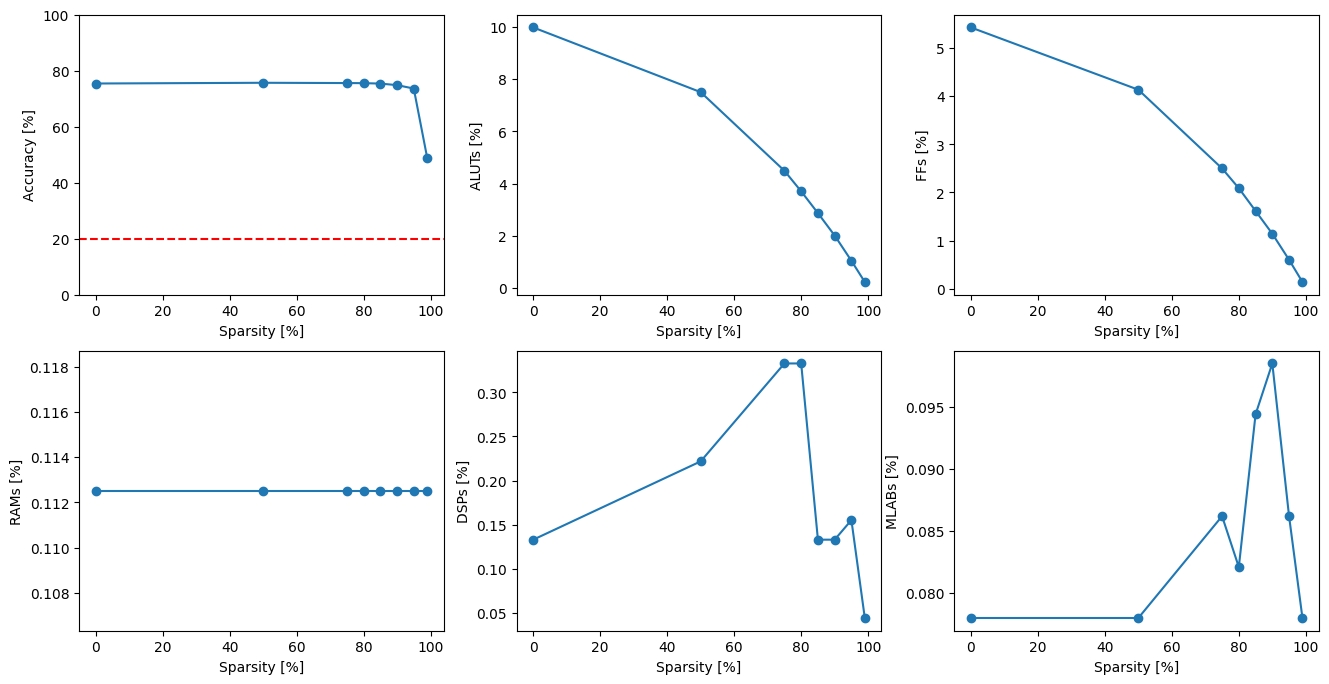

In [150]:
# SOLUTION: plot accuracy and resource usage as function of sparsity
fig, axs = plt.subplots(2,3, figsize=(16,8))

# Top left: accuracy
axs[0][0].plot(100*np.array(sparsities), 100*np.array(hls_accuracy_prune_list), marker='o', label='Baseline')
axs[0][0].set_xlabel("Sparsity [%]")
axs[0][0].set_ylabel("Accuracy [%]")
axs[0][0].axhline(20, color='red', ls='--', label="Random choice")
axs[0][0].set_ylim(0,100)

# Top middle: ALUT usage
axs[0][1].plot(100*np.array(sparsities), 100*np.array(resource_usage_prune_list['ALUTs']), marker='o', label='Baseline')
axs[0][1].set_xlabel("Sparsity [%]")
axs[0][1].set_ylabel("ALUTs [%]")

# Top right: FF usage
axs[0][2].plot(100*np.array(sparsities), 100*np.array(resource_usage_prune_list['FFs']), marker='o', label='Baseline')
axs[0][2].set_xlabel("Sparsity [%]")
axs[0][2].set_ylabel("FFs [%]")

# Bottom left: RAM usage
axs[1][0].plot(100*np.array(sparsities), 100*np.array(resource_usage_prune_list['RAMs']), marker='o', label='Baseline')
axs[1][0].set_xlabel("Sparsity [%]")
axs[1][0].set_ylabel("RAMs [%]")

# Top middle: DSP usage
axs[1][1].plot(100*np.array(sparsities), 100*np.array(resource_usage_prune_list['DSPs']), marker='o', label='Baseline')
axs[1][1].set_xlabel("Sparsity [%]")
axs[1][1].set_ylabel("DSPs [%]")

# Top right: MLAB usage
axs[1][2].plot(100*np.array(sparsities), 100*np.array(resource_usage_prune_list['MLABs']), marker='o', label='Baseline')
axs[1][2].set_xlabel("Sparsity [%]")
axs[1][2].set_ylabel("MLABs [%]")

<div style="background-color:#C2F5DD">


### Exercise (extension)

Now you have two methods for reducing the resource usage, whilst maintaing the same performance as the baseline model:
* Quantization-aware training
* Pruning

In this exercise you should train and synthesize a model that uses both quantization aware training and pruning to achieve roughly the same accuracy as the baseline model.

Investigate how large are the savings in resource usage in comparison to the baseline model before the accuracy drops?

</div>

In [152]:
# TO DO

<div style="background-color:#FFCCCC">

### Competition

Who can achieve the lowest resource usage for an accuracy on the test dataset of greater than 74%?

The metric for resource usage is: (Fraction of used ALUTs) x (Fraction of used FFs) i.e.
`resource_usage['ALUTs']*resource_usage['ALUTs']`

Let one of the demonstrators know when you are happy with your result, and provide proof of the accuracy and the resource usage metric. We will add the results to a database and announce the winner at the end of the course!